# CO2-ppm Atmoshperic Carbon Dioxide

This dataset is obtained from the US Goverment's Earth system research laboratory, Global Monitoring division. Data are reported as dry air mole fraction defined as the number of all molecules in air, including CO2 itself, after water vapor has been removed. The mole fraction is represented as Parts Per Million (ppm)

In [7]:
# import the dataset
import pandas as pd
df = pd.read_csv('co2.csv',index_col='date',parse_dates=True)

In [8]:
# print 5 rows of co2
df.head()

,CO2_ppm
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


The dataset contains monthly average co2_ppm from 01-03-1958 to 01-09-2018. 

In [9]:
# check for missing values
df.isnull().sum()

CO2_ppm    0
dtype: int64

There is no missing values in our data

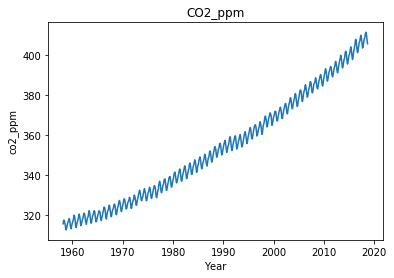

In [10]:
# plot the data
import matplotlib.pyplot as plt
plt.plot(df)
plt.xlabel('Year')
plt.ylabel('co2_ppm')
plt.title('CO2_ppm')
plt.show()

From the plot, we can understand that there is a positive or upward trend and the time series is seasonal with frequency of 12.

C:\Users\KANNAN\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


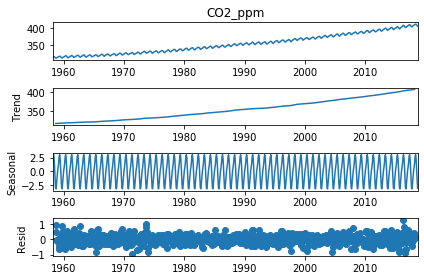

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(df['CO2_ppm'], freq = 12)
decomp_results.plot()
plt.show()

In [12]:
# train and test split of data
train = df.iloc[0:706]
test = df.iloc[706:]

we will use data from 01-03-1958 to 01-12-2016 for training and data from 01-01-2017 to 01-09-2018 for testing.

# Identification

To model a time series it must be stationary. To check stationarity of a time series we can use augmented dicky-fuller test

# Augmented Dicky-Fuller Test

It is a statistical test, where the null hypothesis is that timeseries is non-stationary due to trend.

In [133]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
print(result[1])

1.0


since p-value is not less that 0.05, we fail to reject null hypothesis that time is non-stationary

In [134]:
result = adfuller(train.diff().diff(12).dropna())
print(result[1])

2.878177992956049e-19


Now p-value is < 0.05, we reject null hypothesis and assume our time series is stationary.

# ACF and PACF Plots

The main ways to identify correct model order is by using AutoCorrelation and PartialAutocorrelation plots.

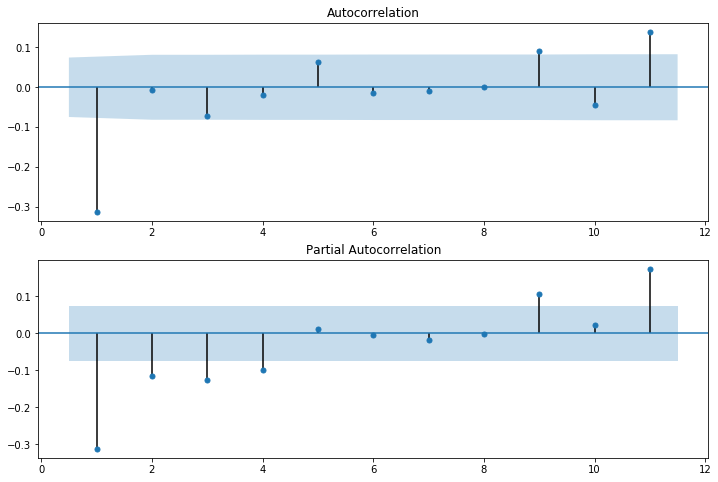

In [136]:
# Import
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8)) 
# Plot the ACF of df
plot_acf(train.diff().diff(12).dropna(), lags=11, zero=False, ax=ax1)
# Plot the PACF of df
plot_pacf(train.diff().diff(12).dropna(), lags=11, zero=False, ax=ax2)
plt.show()

For Non-Seasonal, both the ACF and PACF plots tail off so we have an ARMA model.
ARMA(p=1, d=1, q=1)

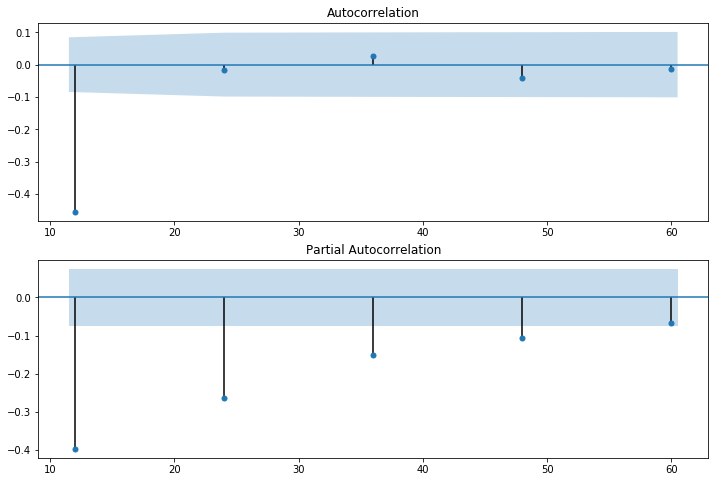

In [115]:
# Make list of lags
lags = [12, 24, 36, 48, 60]
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8)) 
# Plot the ACF of df
plot_acf(train.diff().diff(12).dropna(), lags=lags, zero=False, ax=ax1)
# Plot the PACF of df
plot_pacf(train.diff().diff(12).dropna(), lags=lags, zero=False, ax=ax2)
plt.show()

For Seasonal, ACF cuts off after lag-1 and PACF tails off. so we have an MA(P=0, D=1, Q=1, S=12) model.

# Estimation

The auto_arima function from pmdarima package loops over the model orders to find the best one. Here we will use aic to find the best model order.

In [13]:
# Import pmdarima as pm
import pmdarima as pm
# Create model for SARIMAX(p,1,q)(P,1,Q)12
model = pm.auto_arima(train,
                      seasonal=True, m=12,
                      d=1, D=1, 
                      start_p=0, start_q=0,
                      max_p=3, max_q=3,
                      max_P=3, max_Q=3,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=803.596, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=560.304, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=369.600, Time=0.94 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=716.484, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=371.583, Time=1.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=371.582, Time=3.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=541.266, Time=0.47 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=373.434, Time=3.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=367.425, Time=2.46 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=714.765, Time=0.21 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=369.403, Time=1.72 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=369.402, Time=4.75 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AI

auto_arima finds (1,1,1)(0,1,1,12) as best model order as it has lowest AIC score when compared to all other orders.

In [16]:
# Fitting the model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model =  SARIMAX(train,order=(1,1,1),seasonal_order = (0,1,1,12))
results = model.fit()
print(results.summary())

C:\Users\KANNAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\KANNAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                            CO2_ppm   No. Observations:                  706
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -179.713
Date:                            Fri, 18 Dec 2020   AIC                            367.425
Time:                                    11:16:53   BIC                            385.590
Sample:                                03-01-1958   HQIC                           374.450
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2092      0.083      2.509      0.012       0.046       0.373
ma.L1         -0.5678      0.072   

# Model Diagnostics

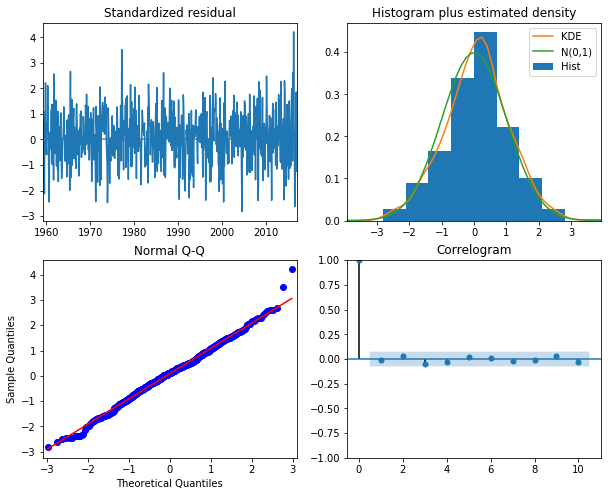

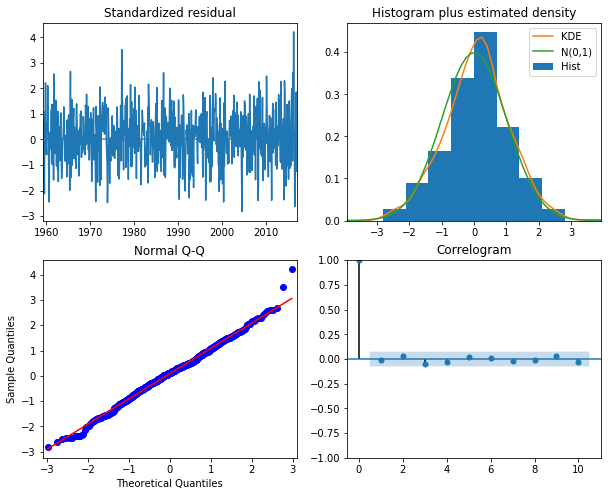

In [17]:
# plot model diagnostics
results.plot_diagnostics(figsize=(10,8))

# 1. One-step ahead standardized residuals
Thers is no obvious structure in the residuals so our model is good

# 2. Histogram plus estimated Density
Since both KDE and Nline are almost same, our model is good

# 3. Normal Q-Q
If our residuals are normally distributed then all the values should lie on the line except some values at either end. since our residuals are normally distributed, our model is good

# 4. Correlogram
It is the ACF plot of the residuals rather than the data. since 95% of the correlation for lag > 0 is not significant our model is good.

# Forecasting

In [62]:
# Get forecasting for test data
forecast = results.get_forecast(steps=21)
forecast = forecast.predicted_mean

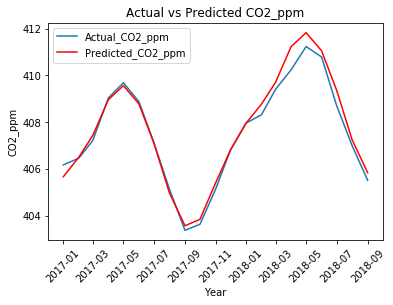

In [63]:
# plot test vs prediction
plt.plot(test)
plt.plot(forecast,color='red')
plt.xlabel('Year')
plt.ylabel('CO2_ppm')
plt.title('Actual vs Predicted CO2_ppm')
plt.legend(['Actual_CO2_ppm','Predicted_CO2_ppm'],loc='best')
plt.xticks(rotation=45)
plt.show()

In [64]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(test,forecast))

0.27490673779708513


In [69]:
# Root Mean Squared Error
from sklearn.metrics import mean_squared_error
import numpy as np
print(np.sqrt(mean_squared_error(test,forecast)))

0.36654118882027903
